This notebook contains the code for the Kaggle competition https://www.kaggle.com/c/auto-insurance-fall-2017 .

It is orgnanized in 4 main parts:
1. Data Exploration + Feature Engineering
2. Preprocessing
3. Models
4. Predictions

Standard imports

In [755]:
import os
import math
import re
from decimal import Decimal

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# 1. Data exploration + Feature Engineering

This part will details sequentially all th steps that I took when exploring the dataset. It also covers all the decisions I made regarding feature engineering of non-numerical/ categorical featues.

### 1.0 - Class Imbalance

Load dataset

the column 'TARGET_AMT' is not present in the test set, we can drop it.

In [794]:
train_df = pd.read_csv("train_auto.csv")
test_df = pd.read_csv("test_auto.csv")

train_df = train_df.drop(columns=['INDEX'])
train_df = train_df.drop(columns=['TARGET_AMT'])

test_df = test_df.drop(columns=['INDEX'])
test_df = test_df.drop(columns=['TARGET_FLAG'])
test_df = test_df.drop(columns=['TARGET_AMT'])

train_df.head()


,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


Class distribution

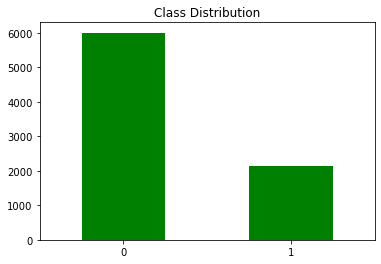

In [795]:
train_df['TARGET_FLAG'].value_counts().plot(kind='bar', rot=0, color='green')
plt.title('Class Distribution')
plt.show()

### 1.1 - Some categorial variables can easily be preprocessed with binary one-hot encoding

All categorical variables with 2 modes can be transformed into a binary boolean variable.

In [796]:
replace_dict = {'No'  : 0, 'z_No': 0, 'no'  : 0, 'Yes' : 1, 'yes' : 1,
                'z_F': 0, 'M': 1,
                'Commercial': 0, 'Private': 1,
                'Highly Urban/ Urban': 0, 'z_Highly Rural/ Rural': 1,
               }
categorical = ['PARENT1','MSTATUS','RED_CAR','REVOKED', 'URBANICITY', 'SEX', 'CAR_USE', 'URBANICITY']

for column in categorical:
    train_df.loc[:, column] = train_df.loc[:, column].replace(replace_dict)
    test_df.loc[:, column] = test_df.loc[:, column].replace(replace_dict)
    
train_df.head()

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,0,0,60.0,0,11.0,"$67,349",0,$0,0,1,...,"$14,230",11,Minivan,1,"$4,461",2,0,3,18.0,0
1,0,0,43.0,0,11.0,"$91,449",0,"$257,252",0,1,...,"$14,940",1,Minivan,1,$0,0,0,0,1.0,0
2,0,0,35.0,1,10.0,"$16,039",0,"$124,191",1,0,...,"$4,010",4,z_SUV,0,"$38,690",2,0,3,10.0,0
3,0,0,51.0,0,14.0,NaN,0,"$306,251",1,1,...,"$15,440",7,Minivan,1,$0,0,0,0,6.0,0
4,0,0,50.0,0,NaN,"$114,986",0,"$243,925",1,0,...,"$18,000",1,z_SUV,0,"$19,217",2,1,3,17.0,0


### 1.3 - Some numerical categories in the dataset can be transformed to floats

Some values in the dataset (e.g INCOME, HOME_VAL) are strings, but they represents amounts in dollars so they can be easily converted to floats.

In [797]:
non_numerical_idx = np.where((train_df.dtypes != np.float) & (train_df.dtypes != np.int))[0] 
train_df.iloc[:, non_numerical_idx].head()

,INCOME,HOME_VAL,EDUCATION,JOB,BLUEBOOK,CAR_TYPE,OLDCLAIM
0,"$67,349",$0,PhD,Professional,"$14,230",Minivan,"$4,461"
1,"$91,449","$257,252",z_High School,z_Blue Collar,"$14,940",Minivan,$0
2,"$16,039","$124,191",z_High School,Clerical,"$4,010",z_SUV,"$38,690"
3,NaN,"$306,251",<High School,z_Blue Collar,"$15,440",Minivan,$0
4,"$114,986","$243,925",PhD,Doctor,"$18,000",z_SUV,"$19,217"


In [798]:
import math 

to_numerical = ['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM']
for column in to_numerical:
    for i, x in enumerate(train_df[column].values):
        if type(x) is not str and math.isnan(x):
            x = np.nan
        else:
            x = float((re.sub(r'[^\d.]', '', x)))
        x = np.log(x)
        if x == -np.inf:
            x = 0
        train_df[column].values[i] = x

for column in to_numerical:
    for i, x in enumerate(test_df[column].values):
        if type(x) is not str and math.isnan(x):
            x = np.nan
        else:
            x = float((re.sub(r'[^\d.]', '', x)))
        x = np.log(x)
        if x == -np.inf:
            x = 0
        test_df[column].values[i] = x

train_df.head()

//anaconda3/envs/berkeley/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
//anaconda3/envs/berkeley/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,0,0,60.0,0,11.0,11.117643,0,0,0,1,...,9.563108,11,Minivan,1,8.403128,2,0,3,18.0,0
1,0,0,43.0,0,11.0,11.423537,0,12.457811,0,1,...,9.611797,1,Minivan,1,0,0,0,0,1.0,0
2,0,0,35.0,1,10.0,9.682779,0,11.729576,1,0,...,8.296547,4,z_SUV,0,10.563336,2,0,3,10.0,0
3,0,0,51.0,0,14.0,NaN,0,12.63216,1,1,...,9.644717,7,Minivan,1,0,0,0,0,6.0,0
4,0,0,50.0,0,NaN,11.652566,0,12.404616,1,0,...,9.798127,1,z_SUV,0,9.863551,2,1,3,17.0,0


Let's put all the numerical features in a list (This will be useful later).

In [799]:
numerical_features = to_numerical + ['AGE', 'CAR_AGE', 'YOJ']
numerical_features

['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM', 'AGE', 'CAR_AGE', 'YOJ']

***Missing values***

- If more than 50% of the values in the column are NaN, we remove the column (this not the case here)
- Otherwise, we replace NaN values with the mean value. If it is a numerical feature, we use the arithmetic mean. If it a categorical variable, we use the most frequent mode.

In [800]:
null_values = train_df.isnull().sum()
null_values = round((null_values/train_df.shape[0] * 100), 2)
print('Frequency of missing values for each variable')
null_values.sort_values(ascending=False)

Frequency of missing values for each variable


JOB            6.45
CAR_AGE        6.25
HOME_VAL       5.69
YOJ            5.56
INCOME         5.45
AGE            0.07
TARGET_FLAG    0.00
TIF            0.00
MVR_PTS        0.00
REVOKED        0.00
CLM_FREQ       0.00
OLDCLAIM       0.00
RED_CAR        0.00
CAR_TYPE       0.00
TRAVTIME       0.00
BLUEBOOK       0.00
CAR_USE        0.00
KIDSDRIV       0.00
EDUCATION      0.00
SEX            0.00
MSTATUS        0.00
PARENT1        0.00
HOMEKIDS       0.00
URBANICITY     0.00
dtype: float64

Handling missing values

Train

In [801]:
# Numerical columns
null_values_columns_train = train_df.isnull().sum().sort_values(ascending=False)
null_values_columns_test = test_df.isnull().sum().sort_values(ascending=False)

numerical_col_null_values_train = train_df[null_values_columns_train.index].select_dtypes(include=['float64', 'int64']).columns
numerical_col_null_values_test = test_df[null_values_columns_test.index].select_dtypes(include=['float64', 'int64']).columns

# for each column
for c in numerical_col_null_values_train:
    # Get the mean
    mean = train_df[c].mean()
    # replace the NaN by mean
    train_df[c].fillna(mean, inplace=True)
    
# for each column
for c in numerical_col_null_values_test:
    # Get the mean
    mean = test_df[c].mean()
    # replace the NaN by mean
    test_df[c].fillna(mean, inplace=True)


Test

In [802]:
##### Categorical columns
categ_col_null_values_train = train_df[null_values_columns_train.index].select_dtypes(include=['object']).columns
categ_col_null_values_test = test_df[null_values_columns_test.index].select_dtypes(include=['object']).columns

# for each column: train
for c in categ_col_null_values_train:
    # Get the most frequent value (mode)
    mode = train_df[c].value_counts().index[0]
    # replace the NaN by mode
    train_df[c].fillna(mode, inplace=True)    
    
# for each column: test
for c in categ_col_null_values_test:
    # Get the most frequent value (mode)
    mode = test_df[c].value_counts().index[0]
    # replace the NaN by mode
    test_df[c].fillna(mode, inplace=True)    
    

In [803]:
print('Frequency of missing values for each variable, after processing')
null_values = train_df.isnull().sum()
null_values

Frequency of missing values for each variable, after processing


TARGET_FLAG    0
KIDSDRIV       0
AGE            0
HOMEKIDS       0
YOJ            0
INCOME         0
PARENT1        0
HOME_VAL       0
MSTATUS        0
SEX            0
EDUCATION      0
JOB            0
TRAVTIME       0
CAR_USE        0
BLUEBOOK       0
TIF            0
CAR_TYPE       0
RED_CAR        0
OLDCLAIM       0
CLM_FREQ       0
REVOKED        0
MVR_PTS        0
CAR_AGE        0
URBANICITY     0
dtype: int64

### 1.4 Ordinal variables : 

The modes for the variable 'EDUCATION' can be orgzanized in increasing order (High school (0) --> PhD (3))

In [804]:
# Train
new_values = []
for i, x in enumerate(train_df['EDUCATION'].values):
    if x == 'z_High School' or x == '<High School':
         new_values.append(0)
    elif x == 'Bachelors':
        new_values.append(1)
    elif x == 'Masters':
        new_values.append(2)
    elif x == 'PhD':
        new_values.append(3)
train_df['EDUCATION'] = new_values

# Test
new_values = []
for i, x in enumerate(test_df['EDUCATION'].values):
    if x == 'z_High School' or x == '<High School':
         new_values.append(0)
    elif x == 'Bachelors':
        new_values.append(1)
    elif x == 'Masters':
        new_values.append(2)
    elif x == 'PhD':
        new_values.append(3)
test_df['EDUCATION'] = new_values

test_df

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,0,48.0,0,11.000000,10.875799,0,0.000000,0,1,1,...,9.997433,1,Van,1,0.000000,0,0,2,10.0,0
1,1,40.0,1,11.000000,10.835947,1,0.000000,0,1,0,...,9.848503,6,Minivan,0,8.100161,1,0,2,1.0,0
2,0,44.0,2,12.000000,10.680194,1,0.000000,0,0,0,...,8.682708,10,z_SUV,0,0.000000,0,0,0,10.0,1
3,0,35.0,2,10.379091,9.961945,1,0.000000,0,1,0,...,9.130214,6,Pickup,0,0.000000,0,1,0,4.0,1
4,0,59.0,0,12.000000,11.378937,0,0.000000,0,1,0,...,9.643421,1,Minivan,1,10.711235,2,0,4,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2136,0,46.0,0,0.000000,0.000000,0,0.000000,1,0,0,...,7.313220,6,Sports Car,0,9.929107,1,1,3,8.0,1
2137,0,46.0,0,12.000000,10.680539,0,11.812860,1,1,0,...,9.685332,3,Minivan,0,0.000000,0,0,2,1.0,1
2138,0,55.0,0,10.000000,11.857104,0,12.883151,1,0,2,...,9.957502,10,Sports Car,0,0.000000,0,0,0,22.0,1
2139,0,51.0,0,10.000000,11.763863,0,0.000000,0,1,2,...,10.403050,6,Panel Truck,0,8.292799,3,0,1,15.0,0


### 1.5 Non binary categorical variables

Get the index of these variables

In [805]:
multiple_modes_idx_train = np.where((train_df.dtypes != np.float) & (train_df.dtypes != np.int))[0] 
multiple_modes_idx_test = np.where((test_df.dtypes != np.float) & (test_df.dtypes != np.int))[0] 

Missing value imputation for the `JOB` column

In [806]:
# Inputting missing value for JOB

mean_job_train = train_df.loc[:, 'JOB'].value_counts().index[0]
train_df.loc[:, 'JOB'].fillna(mean_job_train, inplace=True)

mean_job_test = test_df.loc[:, 'JOB'].value_counts().index[0]
test_df.loc[:, 'JOB'].fillna(mean_job_test, inplace=True)

mean_job_train, mean_job_test

('z_Blue Collar', 'z_Blue Collar')

***One hot encoding***: Instead of having one variable with multiple modes, we assigne each mode to a new binary variable in the dataset.

Train

In [807]:
enc = OneHotEncoder(handle_unknown='ignore')
features = enc.fit_transform(train_df.iloc[:, multiple_modes_idx_train]).toarray()

train_df.drop(columns=train_df.columns[multiple_modes_idx_train], inplace=True)

new_columns = []
i = 0
for category in enc.categories_:
    if len(category) == 2:
        new_column = category[0]
        train_df[new_column] = features[:, i]
        new_columns.append(new_column)
        i += 2
    else:
        for new_column in category:
            train_df[new_column] = features[:, i]
            new_columns.append(new_column)
            i += 1


train_df.loc[:, new_columns].head()

,Clerical,Doctor,Home Maker,Lawyer,Manager,Professional,Student,z_Blue Collar,Minivan,Panel Truck,Pickup,Sports Car,Van,z_SUV
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Test

In [808]:
enc = OneHotEncoder(handle_unknown='ignore')
features = enc.fit_transform(test_df.iloc[:, multiple_modes_idx_test]).toarray()

test_df.drop(columns=test_df.columns[multiple_modes_idx_test], inplace=True)

new_columns = []
i = 0
for category in enc.categories_:
    if len(category) == 2:
        new_column = category[0]
        test_df[new_column] = features[:, i]
        new_columns.append(new_column)
        i += 2
    else:
        for new_column in category:
            test_df[new_column] = features[:, i]
            new_columns.append(new_column)
            i += 1


test_df.loc[:, new_columns].head()

,Clerical,Doctor,Home Maker,Lawyer,Manager,Professional,Student,z_Blue Collar,Minivan,Panel Truck,Pickup,Sports Car,Van,z_SUV
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### 1.6 Visual Exploration 

#### Correlation between independant features

We can look at correlation (Spearman) for the **continious** features in the dataset. 

the 'INCOME' and 'YOJ' features seem to be highly correlated. We do not have details (what is 'YOJ'?) on the datset features so it is hard to expand on the meaning of this correlation. 

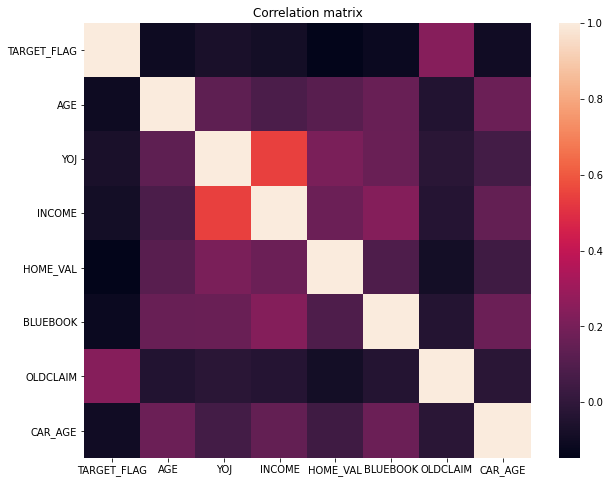

In [809]:
import seaborn as sns
f, ax = plt.subplots(figsize=(10, 8))
df =  train_df.drop(columns=[col for col in train_df.columns if col not in numerical_features + ['TARGET_FLAG']])
corr = df.corr()
sns.heatmap(corr,
            ax=ax
           )
plt.title('Correlation matrix')
plt.show()

#### Correlation with target feature

Again, hard to make a useful interpretation but the 'OLD_CLAIM' variable seems correlated with the target.

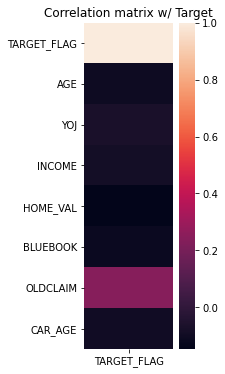

In [810]:
corr_target = corr.drop(columns=[col for col in corr.columns.tolist() if col != 'TARGET_FLAG' and col not in categorical])
f, ax = plt.subplots(figsize=(2, 6))
sns.heatmap(corr_target,
            square=False,
            ax=ax
           )
plt.title('Correlation matrix w/ Target')
plt.show()

#### Distribution Plots

We can visualize the distributions of our continious varibales. Most of them display a gaussian-like behavior with a second mode at 0.

//anaconda3/envs/berkeley/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


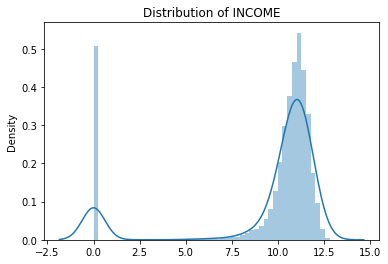

//anaconda3/envs/berkeley/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


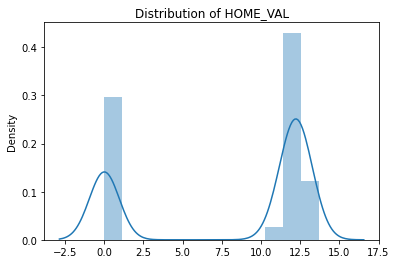

//anaconda3/envs/berkeley/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


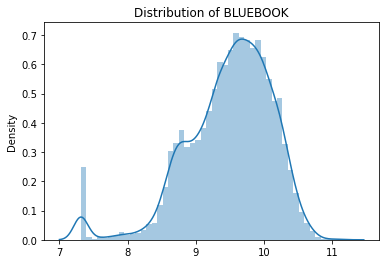

//anaconda3/envs/berkeley/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


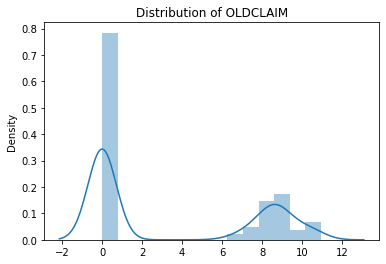

//anaconda3/envs/berkeley/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


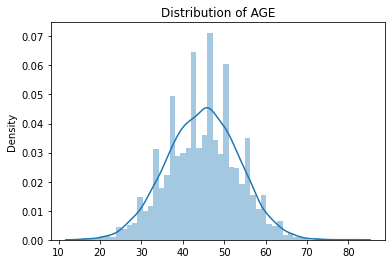

//anaconda3/envs/berkeley/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


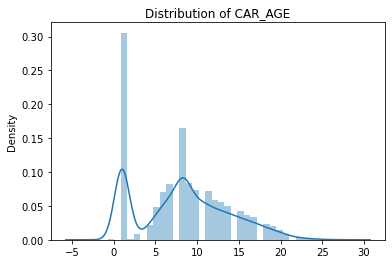

//anaconda3/envs/berkeley/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


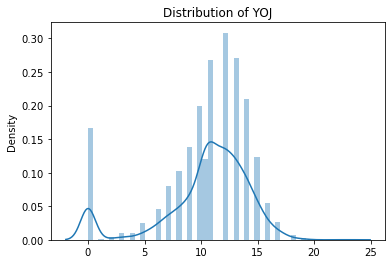

In [811]:
for column in numerical_features:
    
    sns.distplot(x=train_df[column]
                   )
    plt.title('Distribution of {}'.format(column))
    plt.show()

#### Categorical & discrete Features distribution

We use histogram plots to visualize our discrete variables

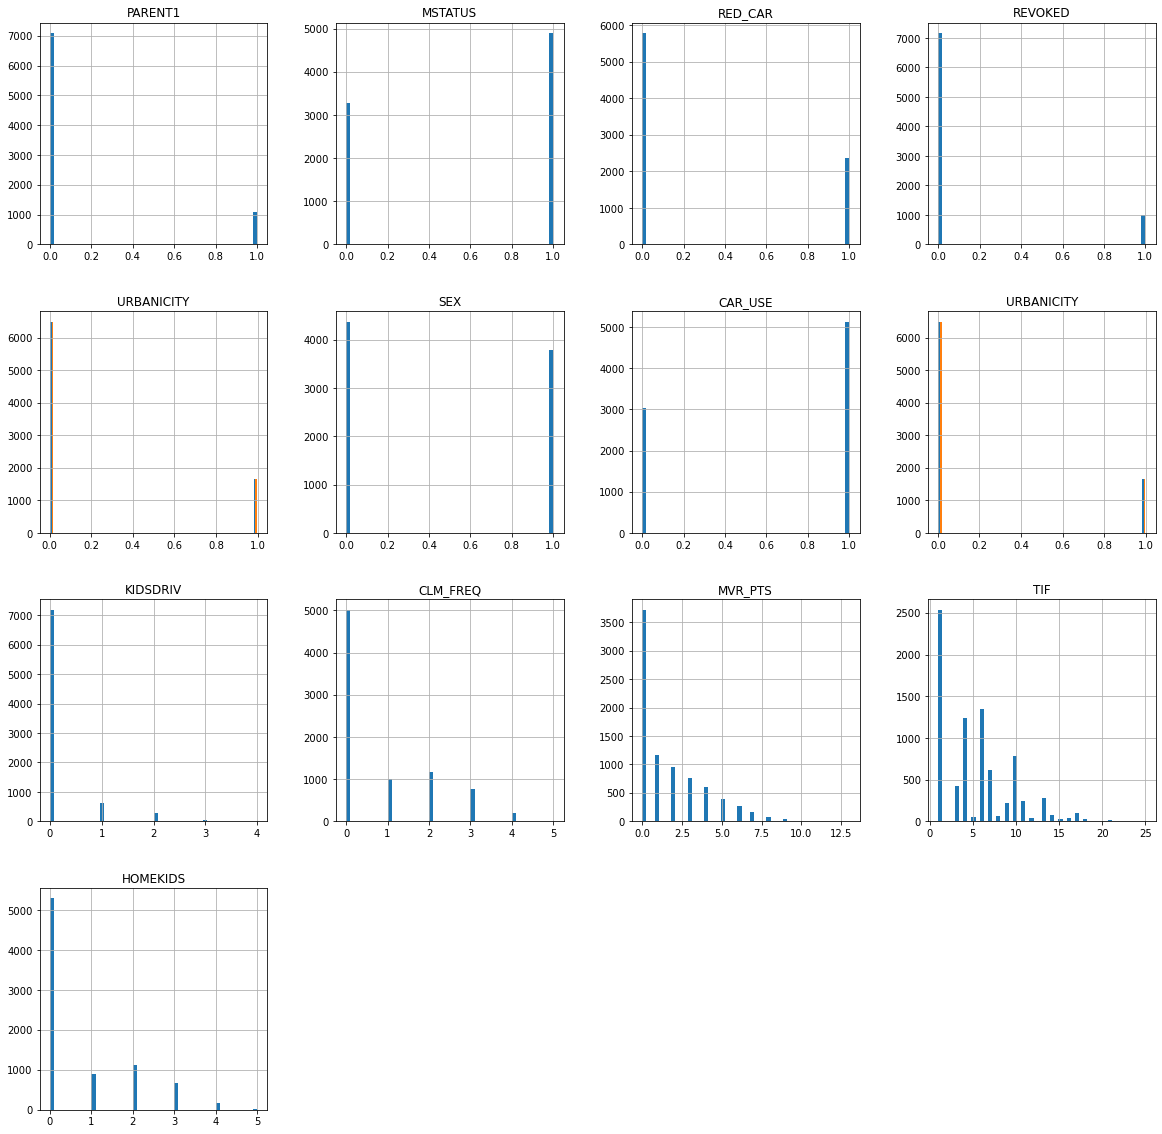

In [812]:
discrete = categorical + ['KIDSDRIV', 'CLM_FREQ', 'MVR_PTS', 'TIF', 'HOMEKIDS']
train_df.loc[:, discrete].hist(bins=50, figsize=(20,20))
plt.show()

# 2. Preprocessing

Now that the feature engineering is done and that we are more familiar with our dataset, it's time for preprocessing.

We will keep it simple and ***scale*** numerical/continious variables

Double checking if we still have missing values in the dataset.

In [813]:
# There are null values?
print(train_df.isnull().values.any())

False


***Train / test split***

In [814]:
from sklearn.model_selection import train_test_split

#train_df, test_df = train_test_split(train_df, test_size=0.1)

train_df.shape #, test_df.shape

(8161, 36)

#### (Numerical) Feature scaling

There are several transformations to be applied in these features, as the datasets are not that bigger, we'll apply `MinMaxScaler(), RobustScaler(), StandardScaler()`.

- MinMaxScaler subtracts the mimimum value in the column and then divides by the difference between the original maximum and original minimum.
-  standardizes a feature by removing the median and dividing each feature by the interquartile range.
- StandardScaler standardizes a feature by removing the mean and dividing each value by the standard deviation.

In [815]:
data = {}
df = pd.read_csv("train_auto.csv")
data = {'train': train_df, 'test': test_df}

num_features = ['AGE',
                'YOJ',
                'INCOME',
                'HOME_VAL',
                'BLUEBOOK',
                'OLDCLAIM',
                'CAR_AGE']

We store the preprocessed datasets in a dictionnary. We will train and evaluate on all fo them for a fair comparison.

In [816]:
import copy
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

# Apply all scalings methods
scaling = {'MinMaxScaler': MinMaxScaler(),
         'RobustScaler': RobustScaler(),
         'StandardScaler': StandardScaler()
        }

# Temporarily save transformed data sets
data_dict = {}

# Get the list of numerical columns
cols_train = copy.copy(num_features)
cols_test = copy.copy(num_features)

# Apply Transformations
for s in scaling.keys():
    print(f"Applying {s}() ...")    

    # Make a copy of the original DFs
    train = data['train'].copy()
    test = data['test'].copy()
    # Apply scaling
    train[cols_train] = scaling[s].fit_transform(train[cols_train])
    test[cols_test] = scaling[s].fit_transform(test[cols_test])    
    # Save the data
    data_dict[f"{s}"] = {'train': train.copy(), 'test': test.copy()}

# Save the new datasets in data dict        
data_dict.update(data_dict)        
print(data_dict.keys())

Applying MinMaxScaler() ...
Applying RobustScaler() ...
Applying StandardScaler() ...
dict_keys(['MinMaxScaler', 'RobustScaler', 'StandardScaler'])


Let's take another look at some distribution plots, after the scaling.

//anaconda3/envs/berkeley/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


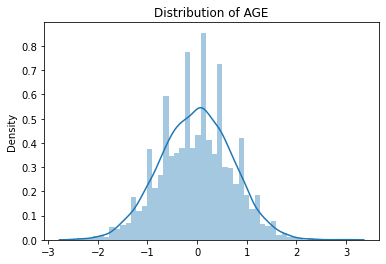

//anaconda3/envs/berkeley/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


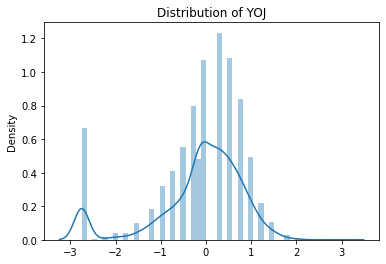

//anaconda3/envs/berkeley/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


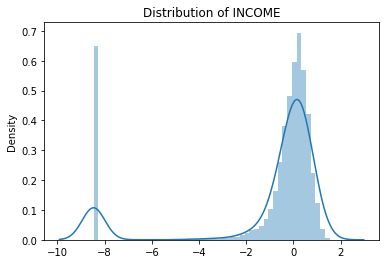

//anaconda3/envs/berkeley/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


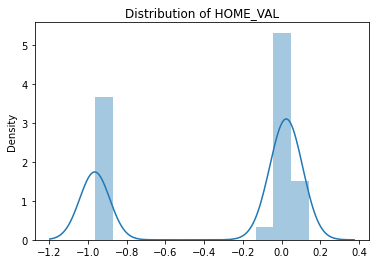

//anaconda3/envs/berkeley/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


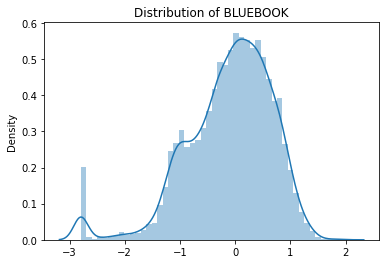

//anaconda3/envs/berkeley/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


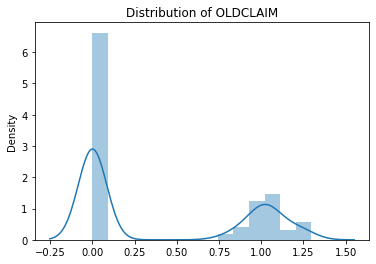

//anaconda3/envs/berkeley/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


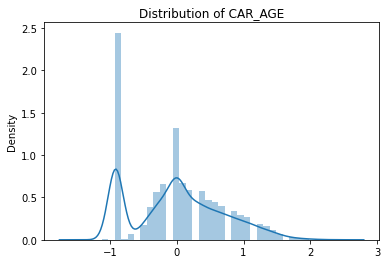

In [817]:
for column in num_features:
    
    sns.distplot(x=data_dict['RobustScaler']['train'][column]
                   )
    plt.title('Distribution of {}'.format(column))
    plt.show()

# 3. Models

We try a bunch of models for binary classification. The training and evaluation process is the same for all methods:

- Train test split.
- 5 fold cross validation. 
- for metrics we use: accuracy, precision, recall and f1 score. Simple accuracy might not be enough, because the classes are imbalanced.
- We choose the model with the best metric on the cross-validation.

***Import all the models we need from scikit-learn***

In [818]:
# Importing packages
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from imblearn.over_sampling import SMOTE, ADASYN
from numpy import sort
import lightgbm as lgb
import xgboost as xgb

We use this helper function to run our 5-fold cross validation

In [819]:
# A function to run train and test for each model
def run_model(name, model, X_train, Y_train, cv_folds=5, verbose=True):   
    
    if verbose: print(f"{name}")
    
    # Use Stratified ShuffleSplit cross-validator
    # Provides train/test indices to split data in train/test sets.
    n_folds = 5
    sss = StratifiedShuffleSplit(n_splits=cv_folds, test_size=0.2, random_state=10)

    # Control the number of folds in cross-validation (5 folds)
    N=1
    
    acc = 0
    precision = 0
    recall = 0
    f1 = 0
    
    # From the generator object gets index for series to use in train and validation
    for train_index, valid_index in sss.split(X_train, Y_train):
        
        X_train = np.array(X_train)
        Y_train = np.array(Y_train)
        # Saves the split train/validation combinations for each Cross-Validation fold
        X_train_cv, X_validation_cv = X_train[train_index], X_train[valid_index]
        Y_train_cv, Y_validation_cv = Y_train[train_index], Y_train[valid_index]
        
        #X_train_cv, X_validation_cv = X_train.loc[train_index,:], X_train.loc[valid_index,:]
        #Y_train_cv, Y_validation_cv = Y_train[train_index], Y_train[valid_index]
        
        # Training the model
        try:
            model.fit(X_train_cv, Y_train_cv,
                      eval_set=[(X_train_cv, Y_train_cv),
                                (X_validation_cv, Y_validation_cv)],
                                  eval_metric='accuracy', verbose=False )        
        except:
            try: 
                model.fit(X_train_cv, Y_train_cv,
                          eval_set=[(X_train_cv, Y_train_cv), (X_validation_cv, Y_validation_cv)],
                          verbose=False)        
            except:
                try:
                    model.fit(X_train_cv, Y_train_cv,
                              verbose=False)
                except:
                    model.fit(X_train_cv, Y_train_cv)
                        
        # Get the class probabilities of the input samples        
        train_pred = model.predict(X_validation_cv)
        
        acc += accuracy_score(Y_validation_cv, train_pred)
        precision += precision_score(Y_validation_cv, train_pred)
        recall += recall_score(Y_validation_cv, train_pred)  
        f1 += f1_score(Y_validation_cv, train_pred)
                
        N += 1
    
    # Compute the mean
    if verbose:
        print("Accuracy : %.4g" % (acc/(N-1)))
        print("Precision: %f" % (precision/(N-1)))
        print("Recall: %f" % (recall/(N-1)))
        print("F1 score: %f" % (f1/(N-1)))
        print()

    # Return the last version 
    return (model, acc/(N-1), precision/(N-1), recall/(N-1), f1/(N-1))

All the models are stored in a dictionnary.

In [820]:
models = {}

models['LogisticRegression'] = LogisticRegression()
models['LinearDiscriminantAnalysis'] = LinearDiscriminantAnalysis()
models['KNeighborsClassifier'] = KNeighborsClassifier(n_jobs=-1)
models['SVM'] = SVC(probability=True)
models['RandomForestClassifier'] = RandomForestClassifier(n_jobs=-1)
models['LGBMClassifier'] = lgb.LGBMClassifier(objective='binary', 
                                              is_unbalance=True, 
                                              max_depth=30, 
                                              learning_rate=0.05, 
                                              n_estimators=500, 
                                              num_leaves=30,
                                             verbose = 0)

models['XGBClassifier'] = XGBClassifier(learning_rate = 0.1,
                          n_estimators = 200,
                          max_depth = 5,
                          min_child_weight = 1,
                          gamma = 0,
                          subsample = 0.8,
                          colsample_bytree = 0.8,
                          objective = 'binary:logistic',
                          n_jobs = -1,
                          scale_pos_weight = 1,
                          verbose = False,
                          seed = 32)


For each model, and each pre-processed dataset, we run a 5-fold cross validation.

In [821]:
datasets = list(data_dict.keys())

results = pd.DataFrame(columns=['Dataset', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1'])

# loop through all datasets and ML models
for d in datasets:
    train = data_dict[d]['train']
    train_x = train.drop(['TARGET_FLAG'], axis=1)
    train_y = train['TARGET_FLAG']
    
    print(f'======= DATASET: {d} =========')
    
    for m in models.keys():
        # Train and test the model
        models[m], acc, precision, recall, f1 = run_model(m,
                                                          models[m],
                                                          train_x,
                                                          train_y
                                                         )  
        
        # Save Results
        results = results.append({'Dataset' : d ,
                                  'Model' : m,
                                  'Accuracy': acc,
                                  'Precision': precision,
                                  'Recall': recall,
                                  'F1': f1},
                                   ignore_index=True
                                )

======= DATASET: MinMaxScaler =========
LogisticRegression


//anaconda3/envs/berkeley/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
//anaconda3/envs/berkeley/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Accuracy : 0.7787
Precision: 0.627325
Recall: 0.397680
F1 score: 0.486436

LinearDiscriminantAnalysis
Accuracy : 0.7769
Precision: 0.621490
Recall: 0.394896
F1 score: 0.482659

KNeighborsClassifier
Accuracy : 0.7286
Precision: 0.471879
Recall: 0.236659
F1 score: 0.314924

SVM


//anaconda3/envs/berkeley/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/envs/berkeley/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/envs/berkeley/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/envs/berkeley/lib/python3.7/site-packages/sklearn/metrics/_classification

Accuracy : 0.7361
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000

RandomForestClassifier
Accuracy : 0.7786
Precision: 0.654188
Recall: 0.341531
F1 score: 0.448651

LGBMClassifier
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001867 seconds.
You can set `force_col_wise=true` to remove the overhead.


//anaconda3/envs/berkeley/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
//anaconda3/envs/berkeley/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000784 seconds.
You can set `force_col_wise=true` to remove the overhead.


//anaconda3/envs/berkeley/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000984 seconds.
You can set `force_col_wise=true` to remove the overhead.


//anaconda3/envs/berkeley/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000842 seconds.
You can set `force_col_wise=true` to remove the overhead.


//anaconda3/envs/berkeley/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001725 seconds.
You can set `force_col_wise=true` to remove the overhead.
Accuracy : 0.7617
Precision: 0.541028
Recall: 0.643155
F1 score: 0.587595

XGBClassifier
[12:49:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:49:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


//anaconda3/envs/berkeley/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
//anaconda3/envs/berkeley/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:49:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:49:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


//anaconda3/envs/berkeley/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:49:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:49:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


//anaconda3/envs/berkeley/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:49:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:49:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


//anaconda3/envs/berkeley/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:49:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:49:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy : 0.7864
Precision: 0.629161
Recall: 0.465893
F1 score: 0.534973

======= DATASET: RobustScaler =========
LogisticRegression


//anaconda3/envs/berkeley/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
//anaconda3/envs/berkeley/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Accuracy : 0.7784
Precision: 0.624912
Recall: 0.401856
F1 score: 0.488755

LinearDiscriminantAnalysis
Accuracy : 0.7769
Precision: 0.621490
Recall: 0.394896
F1 score: 0.482659

KNeighborsClassifier
Accuracy : 0.7302
Precision: 0.477615
Recall: 0.235267
F1 score: 0.314986

SVM


//anaconda3/envs/berkeley/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/envs/berkeley/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/envs/berkeley/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/envs/berkeley/lib/python3.7/site-packages/sklearn/metrics/_classification

Accuracy : 0.7361
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000

RandomForestClassifier
Accuracy : 0.7824
Precision: 0.668297
Recall: 0.348028
F1 score: 0.457628

LGBMClassifier
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001403 seconds.
You can set `force_col_wise=true` to remove the overhead.


//anaconda3/envs/berkeley/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
//anaconda3/envs/berkeley/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000806 seconds.
You can set `force_col_wise=true` to remove the overhead.


//anaconda3/envs/berkeley/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000828 seconds.
You can set `force_col_wise=true` to remove the overhead.


//anaconda3/envs/berkeley/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_col_wise=true` to remove the overhead.


//anaconda3/envs/berkeley/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000828 seconds.
You can set `force_col_wise=true` to remove the overhead.
Accuracy : 0.763
Precision: 0.543182
Recall: 0.645012
F1 score: 0.589509

XGBClassifier
[12:50:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:50:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


//anaconda3/envs/berkeley/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
//anaconda3/envs/berkeley/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:50:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:50:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


//anaconda3/envs/berkeley/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:50:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:50:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


//anaconda3/envs/berkeley/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:50:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:50:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


//anaconda3/envs/berkeley/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:50:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:50:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy : 0.7857
Precision: 0.626799
Recall: 0.465429
F1 score: 0.533863

======= DATASET: StandardScaler =========
LogisticRegression


//anaconda3/envs/berkeley/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
//anaconda3/envs/berkeley/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

Accuracy : 0.7784
Precision: 0.625512
Recall: 0.400464
F1 score: 0.487991

LinearDiscriminantAnalysis
Accuracy : 0.7769
Precision: 0.621490
Recall: 0.394896
F1 score: 0.482659

KNeighborsClassifier
Accuracy : 0.7333
Precision: 0.490373
Recall: 0.251508
F1 score: 0.332297

SVM


//anaconda3/envs/berkeley/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/envs/berkeley/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/envs/berkeley/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
//anaconda3/envs/berkeley/lib/python3.7/site-packages/sklearn/metrics/_classification

Accuracy : 0.7362
Precision: 0.200000
Recall: 0.000464
F1 score: 0.000926

RandomForestClassifier
Accuracy : 0.7824
Precision: 0.667172
Recall: 0.349420
F1 score: 0.458327

LGBMClassifier
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_col_wise=true` to remove the overhead.


//anaconda3/envs/berkeley/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
//anaconda3/envs/berkeley/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_col_wise=true` to remove the overhead.


//anaconda3/envs/berkeley/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


//anaconda3/envs/berkeley/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003003 seconds.
You can set `force_col_wise=true` to remove the overhead.


//anaconda3/envs/berkeley/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001895 seconds.
You can set `force_col_wise=true` to remove the overhead.
Accuracy : 0.7622
Precision: 0.541949
Recall: 0.645476
F1 score: 0.588973

XGBClassifier
[12:51:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:51:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


//anaconda3/envs/berkeley/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
//anaconda3/envs/berkeley/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:51:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:51:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


//anaconda3/envs/berkeley/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:51:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:51:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


//anaconda3/envs/berkeley/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:51:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:51:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


//anaconda3/envs/berkeley/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:51:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:51:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy : 0.7857
Precision: 0.627844
Recall: 0.463573
F1 score: 0.532976



The results are stored in Pandas Dataframe

In [824]:
results

,Dataset,Model,Accuracy,Precision,Recall,F1
0,MinMaxScaler,LogisticRegression,0.778690,0.627325,0.397680,0.486436
1,MinMaxScaler,LinearDiscriminantAnalysis,0.776852,0.621490,0.394896,0.482659
2,MinMaxScaler,KNeighborsClassifier,0.728598,0.471879,0.236659,0.314924
3,MinMaxScaler,SVM,0.736069,0.000000,0.000000,0.000000
4,MinMaxScaler,RandomForestClassifier,0.778567,0.654188,0.341531,0.448651
5,MinMaxScaler,LGBMClassifier,0.761666,0.541028,0.643155,0.587595
6,MinMaxScaler,XGBClassifier,0.786405,0.629161,0.465893,0.534973
7,RobustScaler,LogisticRegression,0.778445,0.624912,0.401856,0.488755
8,RobustScaler,LinearDiscriminantAnalysis,0.776852,0.621490,0.394896,0.482659
9,RobustScaler,KNeighborsClassifier,0.730190,0.477615,0.235267,0.314986


Let's get the model with the best performance on cross-validation

In [825]:
results.max()

Dataset      StandardScaler
Model         XGBClassifier
Accuracy           0.786405
Precision          0.668297
Recall             0.645476
F1                 0.589509
dtype: object

The best performing model is the XGBClassifier, we will use it for inference on out test set.

# 4. Test predicitons

Let's use the XGBClassifier to make predictions on the official test set.
We use StandardScaler() for the scaling.

In [787]:
models['XGBClassifier']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=32, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=32, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbose=False, verbosity=None)

In [789]:
test_x = data_dict['StandardScaler']['test']

test_x

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,...,Manager,Professional,Student,z_Blue Collar,Minivan,Panel Truck,Pickup,Sports Car,Van,z_SUV
0,0,0.350096,0,0.152316,0.414257,0,-1.394799,0,1,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,-0.588758,1,0.152316,0.403976,1,-1.394799,0,1,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0,-0.119331,2,0.397628,0.363795,1,-1.394799,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,-1.175542,2,0.000000,0.178503,1,-1.394799,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,1.641021,0,0.397628,0.544055,0,-1.394799,0,1,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2136,0,0.115383,0,-2.546115,-2.391453,0,-1.394799,1,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2137,0,0.115383,0,0.397628,0.363884,0,0.646526,1,1,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2138,0,1.171594,0,-0.092996,0.667411,0,0.831478,1,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2139,0,0.702167,0,-0.092996,0.643357,0,-1.394799,0,1,2,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [790]:
X_test = np.array(test_x)

X_test.shape, Y_test.shape

((2141, 35), (817,))

***Predictions on test set***

In [826]:
test_pred = models['XGBClassifier'].predict(X_test)

test_pred

array([0, 0, 0, ..., 0, 0, 0])

We add a 'TARGET_FLAG' column to the test data frame, and save it.

In [827]:
test_df['TARGET_FLAG'] = test_pred

test_df

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,...,Professional,Student,z_Blue Collar,Minivan,Panel Truck,Pickup,Sports Car,Van,z_SUV,TARGET_FLAG
0,0,48.0,0,11.000000,10.875799,0,0.000000,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,1,40.0,1,11.000000,10.835947,1,0.000000,0,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,0,44.0,2,12.000000,10.680194,1,0.000000,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,0,35.0,2,10.379091,9.961945,1,0.000000,0,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
4,0,59.0,0,12.000000,11.378937,0,0.000000,0,1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2136,0,46.0,0,0.000000,0.000000,0,0.000000,1,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2137,0,46.0,0,12.000000,10.680539,0,11.812860,1,1,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2138,0,55.0,0,10.000000,11.857104,0,12.883151,1,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2139,0,51.0,0,10.000000,11.763863,0,0.000000,0,1,2,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [828]:
test_df.to_csv('preprocessed_test_and_predictions.csv')